Credits for the following references:

- https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

Using the following data
- https://www.kaggle.com/deltacrot/property-sales#ma_lga_12345.csv

In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
print(os.listdir("../input"))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

['property-sales']
/kaggle/input/property-sales/ma_lga_12345.csv
/kaggle/input/property-sales/raw_sales.csv


## Load Data

In [2]:
data = pd.read_csv("/kaggle/input/property-sales/raw_sales.csv")

In [3]:
data.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
datesold        29580 non-null object
postcode        29580 non-null int64
price           29580 non-null int64
propertyType    29580 non-null object
bedrooms        29580 non-null int64
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [5]:
data.isnull().any().any()

False

No missing data

## Some EDA and Time Series Visualization

### Datesold

In [6]:
print("Time period from {} to {}".format(data.datesold.min(), data.datesold.max()))

Time period from 2007-02-07 00:00:00 to 2019-07-27 00:00:00


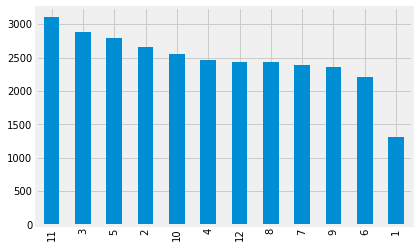

In [7]:
# Monthly number of house sales between 2007 and 2019
pd.to_datetime(data.datesold).dt.month.value_counts().plot('bar')

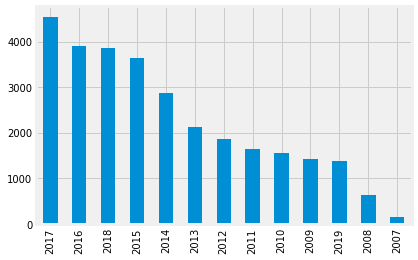

In [8]:
# Yearly number of house sales between 2007 and 2019
pd.to_datetime(data.datesold).dt.year.value_counts().plot('bar')

There were a lot of house sales in 2014 - 2017 but all of a sudden dwindled last year (2019). Interesting.

### postcode

In [9]:
# We bin the postcode for easier analysis
bins = pd.IntervalIndex.from_tuples([(2600, 2700), (2701, 2800), (2801, 2915)])
data['postcode_bin'] = pd.cut(data['postcode'],bins)

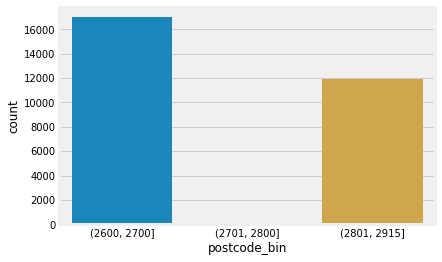

In [10]:
sns.countplot(data['postcode_bin'])

Interesting to see that there were no house sales for postcodes in between 2700 and 2800. We need more context and knowledge to fully interpret this phenomenon but this could possibly point to the fact that certain regions barely had any house sales while other regions had more active house sales? (discrepancy in house sale numbers across different regions in the U.S.)

## propertyType

In [11]:
data.propertyType.value_counts()

house    24552
unit      5028
Name: propertyType, dtype: int64

(-1.1062735784564333,
 1.1060571843127553,
 -1.1058990226661722,
 1.1039583716883157)

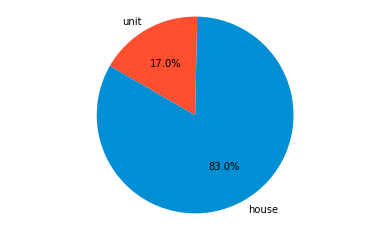

In [12]:
plt.pie(data['propertyType'].value_counts(), labels=['house','unit'], autopct='%1.1f%%', startangle = 150)
plt.axis('equal')

### price by different postcodes groups

In [13]:
data['datesold']= pd.to_datetime(data['datesold'])

In [14]:
from pandas import Interval

# House sales in postcode 2600 - 2700
data1 = data[data.postcode_bin == Interval(2600, 2700, closed='right')]

# House sales in postcode 2801-2915
data2 = data[data.postcode_bin == Interval(2801, 2915, closed='right')]

Text(0, 0.5, 'Average Price')

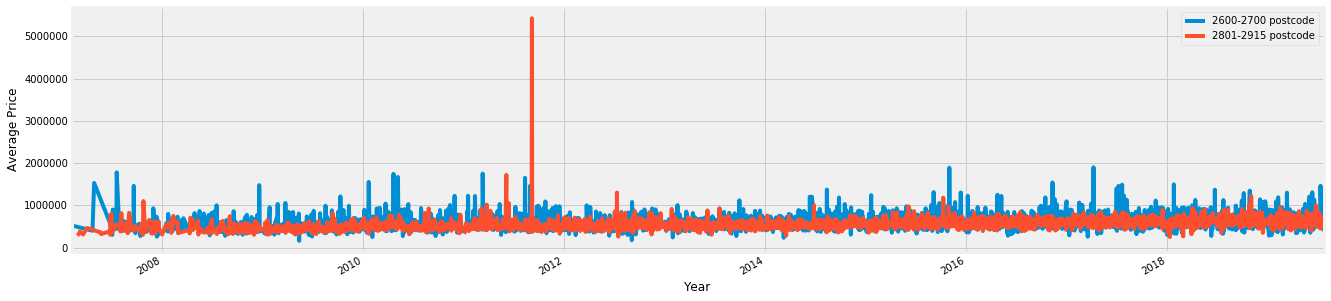

In [19]:
# Average sale price of houses for each of the two postcode bins
rcParams['figure.figsize'] = 20,5 
data1.groupby('datesold').price.mean().plot()
data2.groupby('datesold').price.mean().plot()
plt.legend(['2600-2700 postcode', '2801-2915 postcode'])
plt.xlabel("Year")
plt.ylabel("Average Price")

Some unusually high average sale price of houses detected in mid to late 2011 for houses with 2801-2915 postcodes

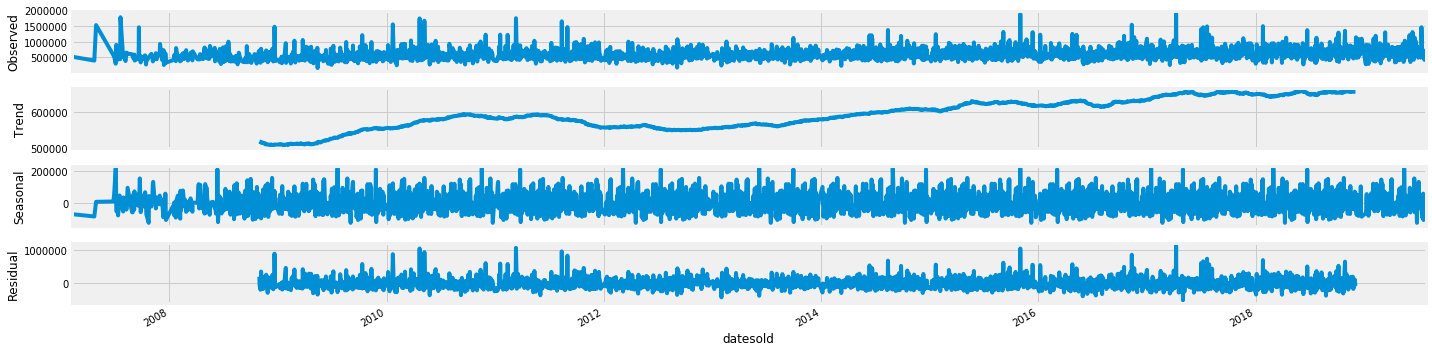

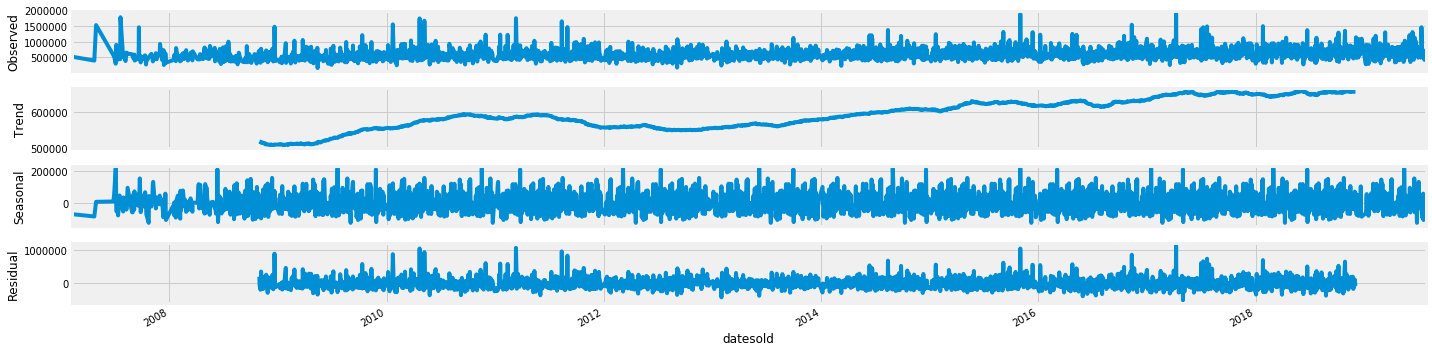

In [25]:
sm.tsa.seasonal_decompose(data1.groupby('datesold').price.mean(), freq=365).plot()

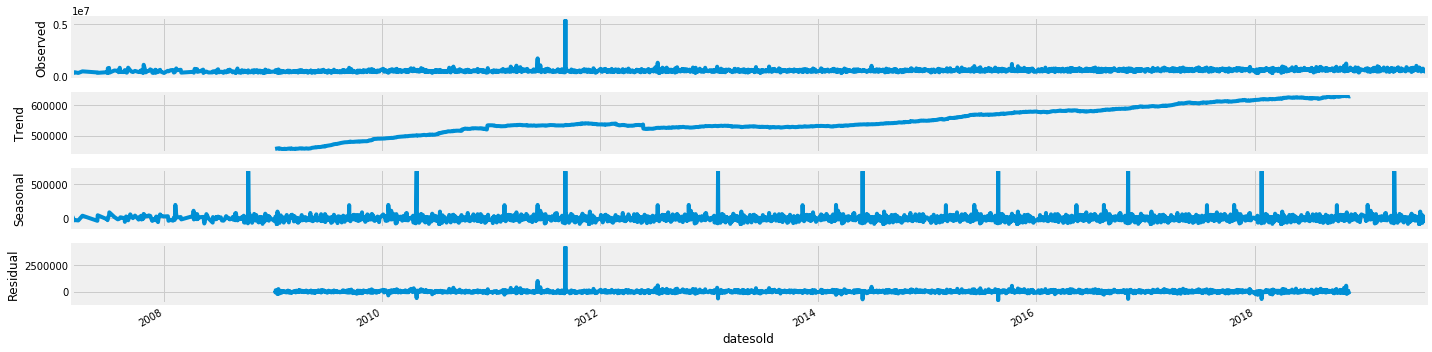

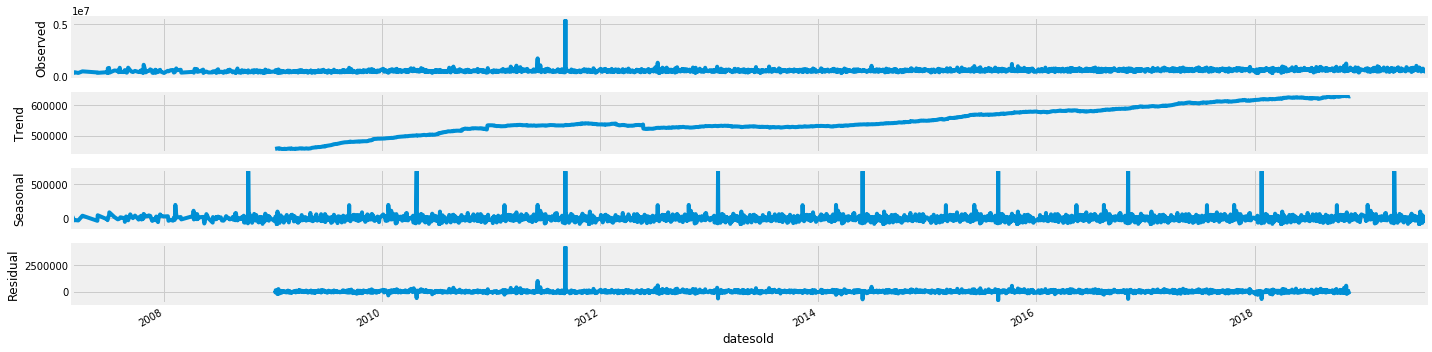

In [24]:
sm.tsa.seasonal_decompose(data2.groupby('datesold').price.mean(), freq=365).plot()

Houses sold in both postcode groups have overall increasing price trends. While houses sold with 2600-2700 postcodes do not have clear seasonality, houses sold with 2801-2915 postcodes have clear seasonality with spikes every 1.2 ish years.

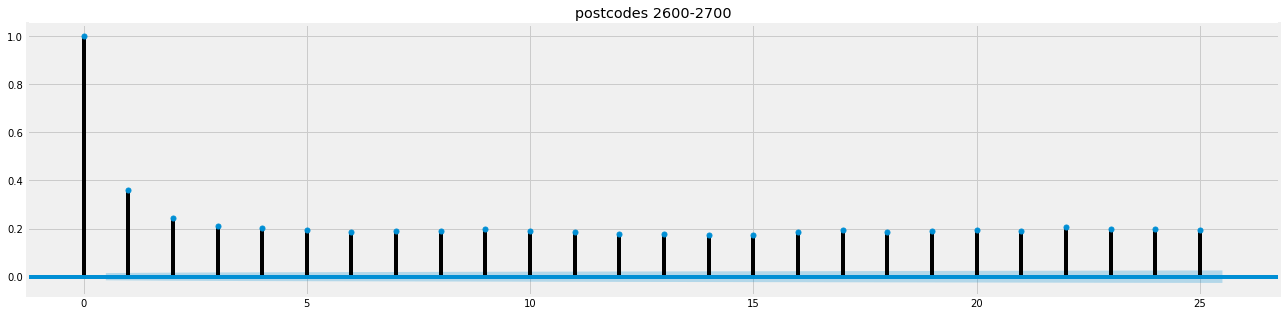

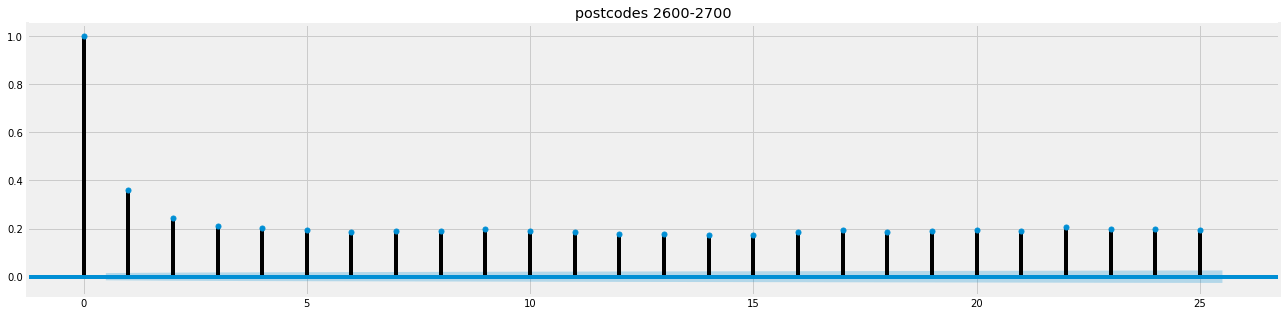

In [26]:
# Auotcorrelation for house sales price for postcodes group 1
plot_acf(data1["price"], lags=25, title="postcodes 2600-2700")

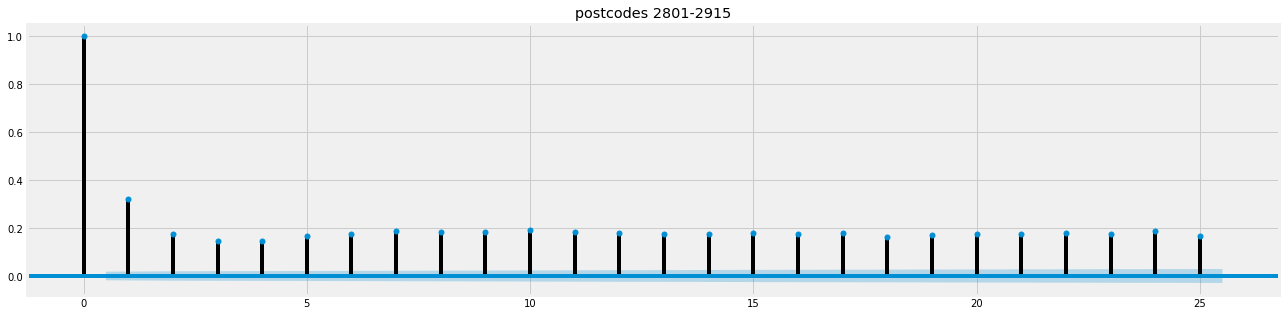

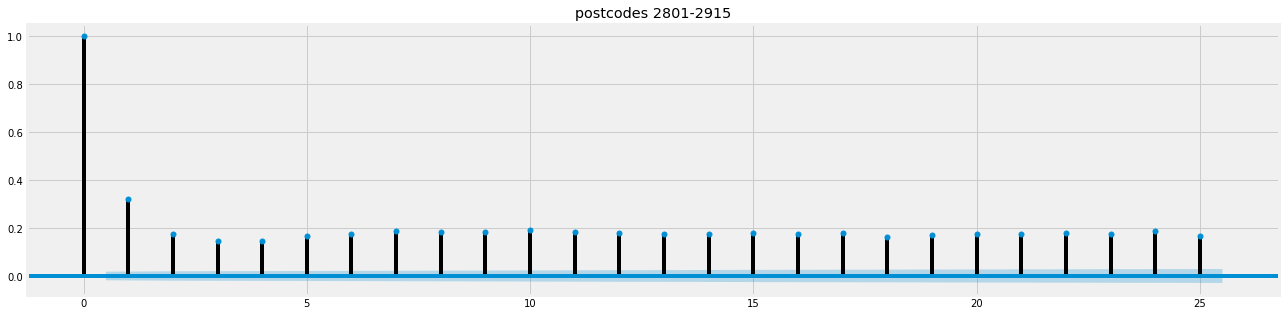

In [27]:
# Auotcorrelation of house sale price for postcodes group 2

plot_acf(data2["price"], lags=25, title="postcodes 2801-2915")

### prices by property Type

In [29]:
data_house = data[data.propertyType == 'house'] 
data_unit = data[data.propertyType == 'unit']

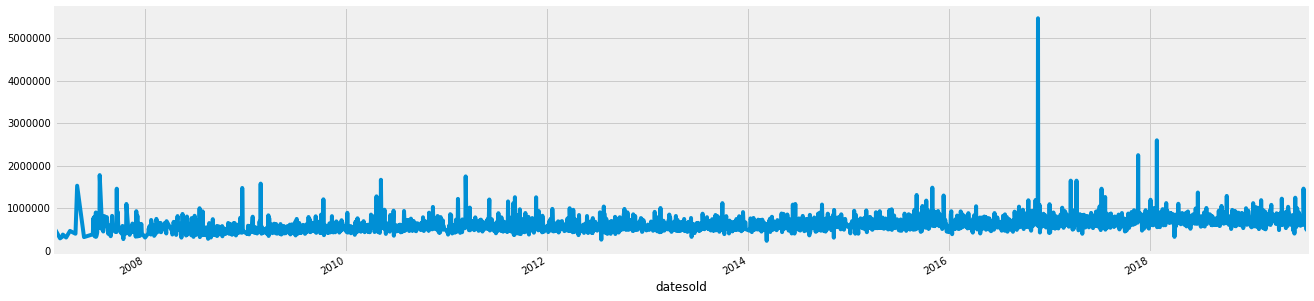

In [32]:
# Average Sale price of house property type over years
data_house.groupby(['datesold']).price.mean().plot()

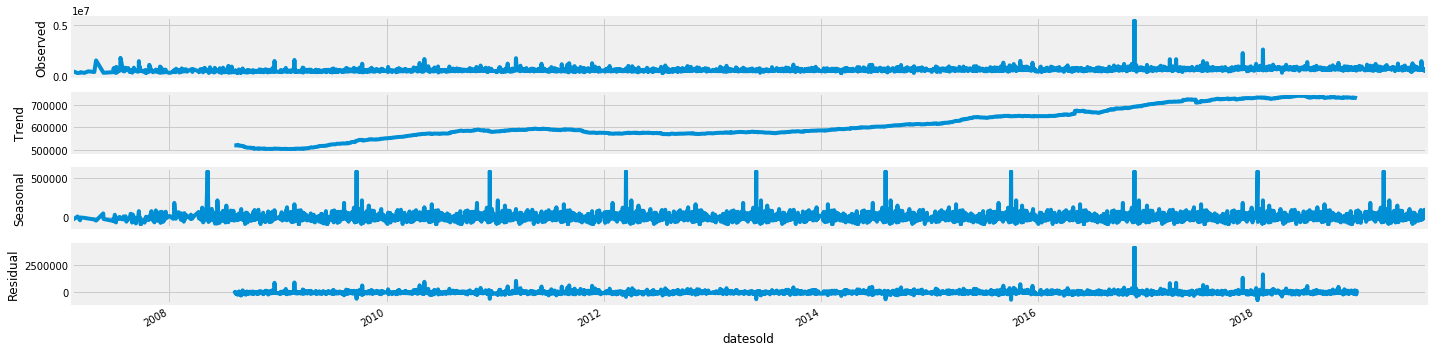

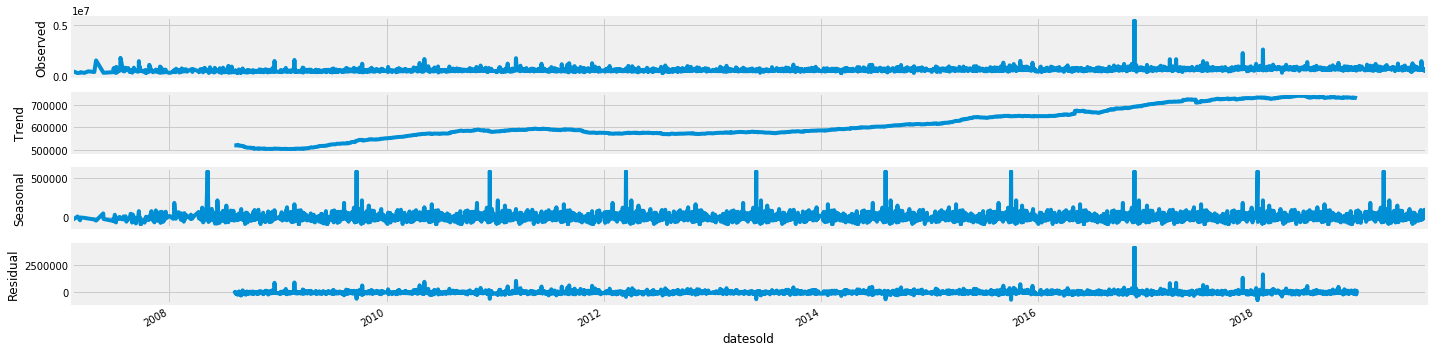

In [36]:
sm.tsa.seasonal_decompose(data_house.groupby('datesold').price.mean(), freq=365).plot()

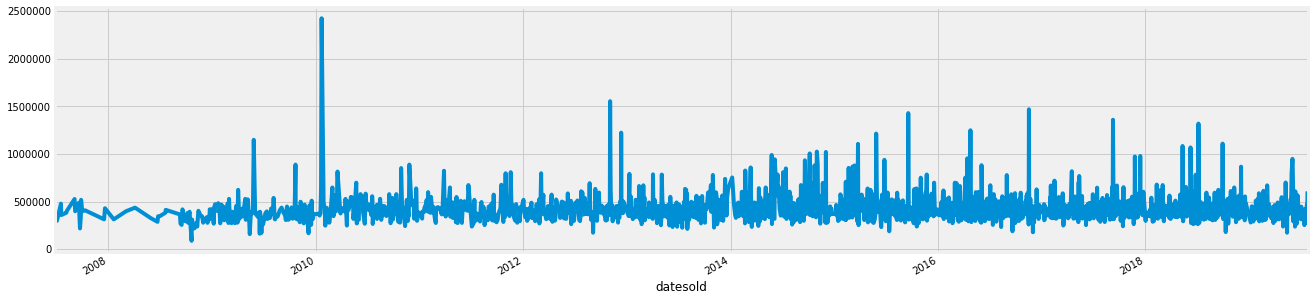

In [33]:
# Average Sale price of units property type over years
data_unit.groupby(['datesold']).price.mean().plot()

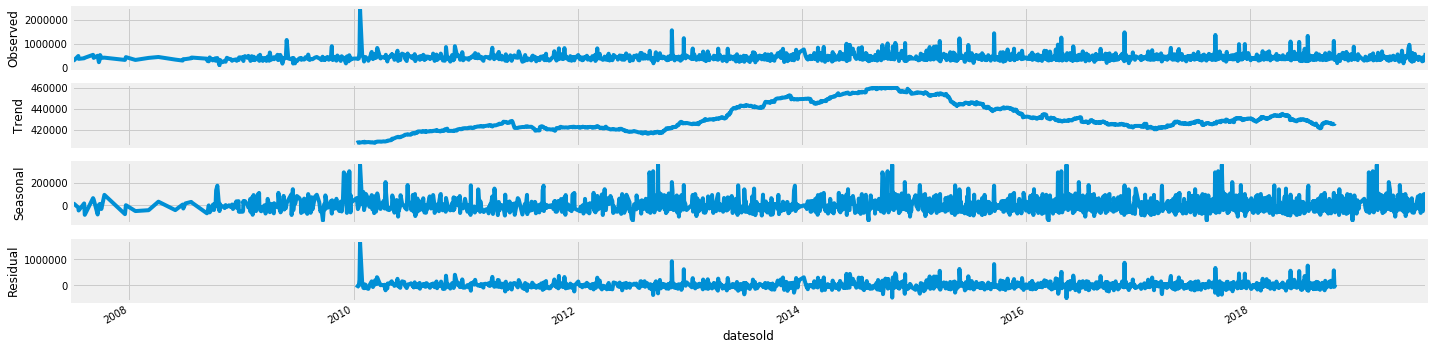

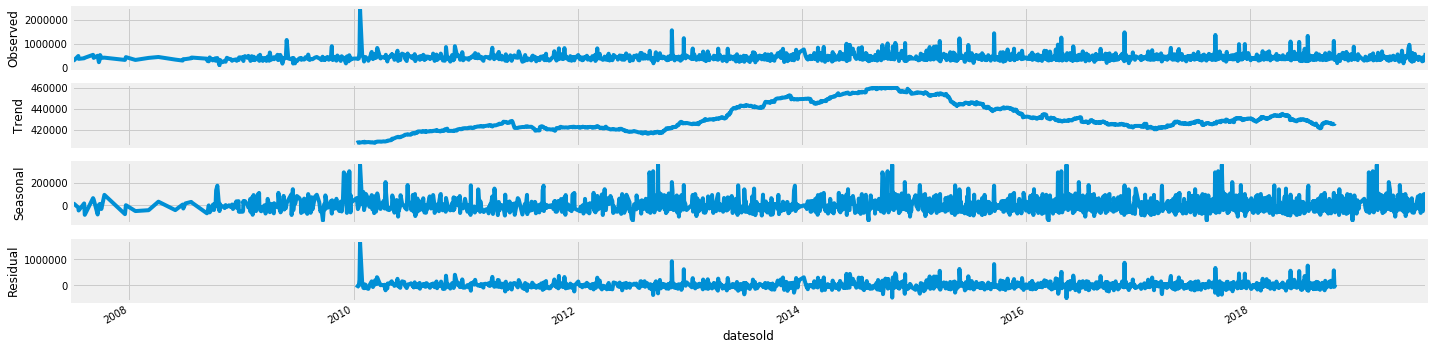

In [37]:
sm.tsa.seasonal_decompose(data_unit.groupby('datesold').price.mean(), freq=365).plot()

### Yearly house sale price variation over time for all house sales

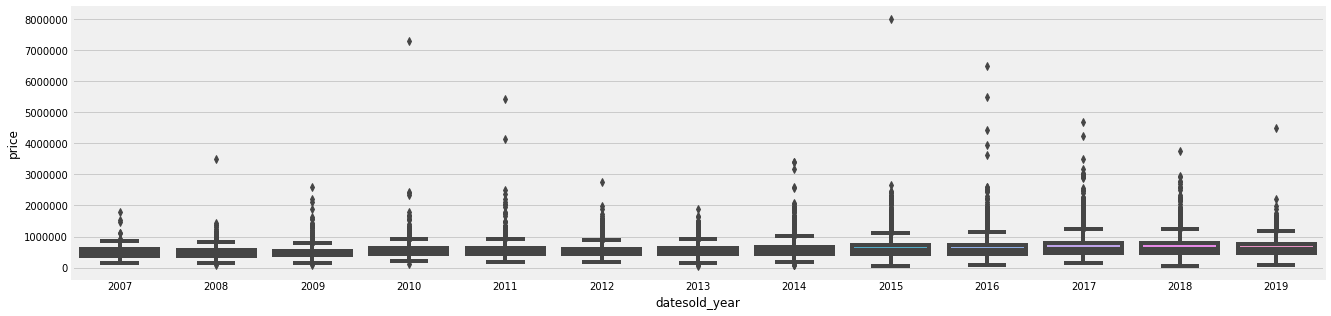

In [45]:
data['datesold_year'] = data['datesold'].dt.year
sns.boxplot(x= 'datesold_year', y = 'price', data=data)

We saw earlier that the number of houses sold was the highest in the past few years (2016-2019) and we see here that the overall distribution of house sale prices is slightly skewed to the left (with more concentrations on higher prices) with more expensive house sales spotted as outliers (although the distribution of house sale prices looks pretty similar over time with gradual upward movements of boxplots)